# **Movie Recommender System using Neural Network Embeddings**

In [ ]:
import pandas as pd
ratings_df=pd.read_csv('/content/rating.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
movie_df=pd.read_csv('/content/movie.csv')
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


**Data Statistics:**

In [ ]:
n_users = len(ratings_df.userId.unique())
n_movies = len(ratings_df.movieId.unique())
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies, "\n")

No of unique users: 459
No of unique movies:  7239 



**Data Preprocessing:**

Let's first observe the number of ratings that each movie has received:

In [ ]:
rating_count = ratings_df[['movieId','rating']].groupby(['movieId']).count()
rating_count

,rating
movieId,
1,150
2,65
3,38
4,9
5,40
...,...
118354,1
118696,2
119141,1


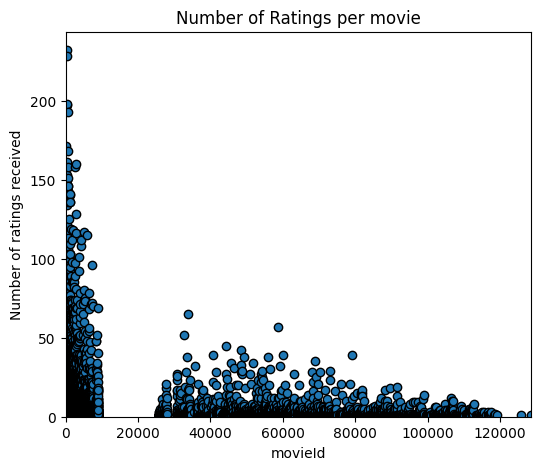

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.scatter(rating_count.index, rating_count.rating, edgecolor='black')
plt.xlim(0,rating_count.index.max())
plt.ylim(0,)
plt.title('Number of Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

We can observe a significant difference between the number of ratings received for different movies, ranging from around 70,000 ratings for the most popular movies to around a single rating for some unpopular movies.

Hence, we will use only those movies that have received more than atleast 5000 user ratings in our recommendation system. This will help us focus on recommending more popular movies, as well as help us increase training and prediction speed.

In [ ]:
import numpy as np
top_movies = ratings_df[ratings_df.groupby('movieId')['rating'].transform('size')>50]
top_movies

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
7,1,223,4.0,2005-04-02 23:46:13
...,...,...,...,...
65296,459,4993,4.0,2011-08-08 14:59:21
65297,459,5378,3.5,2014-01-12 11:07:25
65299,459,5952,4.0,2013-11-25 19:07:50
65304,459,7153,4.0,2011-08-23 14:04:45


We will now merge our ratings and movies databases to get a single dataframe that will be used from now.

In [ ]:
data = pd.merge(movie_df,top_movies)
print(data.shape)
data

(21033, 6)


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...
21028,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,425,5.0,2014-12-07 04:07:31
21029,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,431,5.0,2010-11-06 13:37:20
21030,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,440,3.5,2010-06-03 14:37:59
21031,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,454,3.5,2014-06-16 09:45:31


In [ ]:
n_users = len(data.userId.unique())
n_movies = len(data.movieId.unique())
min_rating = min(data['rating'])
max_rating = max(data['rating'])
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies)
print("Minimum Rating: ", min_rating)
print("Maximum Rating:", max_rating)

No of unique users: 457
No of unique movies:  253
Minimum Rating:  0.5
Maximum Rating: 5.0


Let's also observe the frequency of each rating value in our dataset:

Frequency of each rating from 0.5 to 5.0:



Text(0.5, 0, 'Ratings')

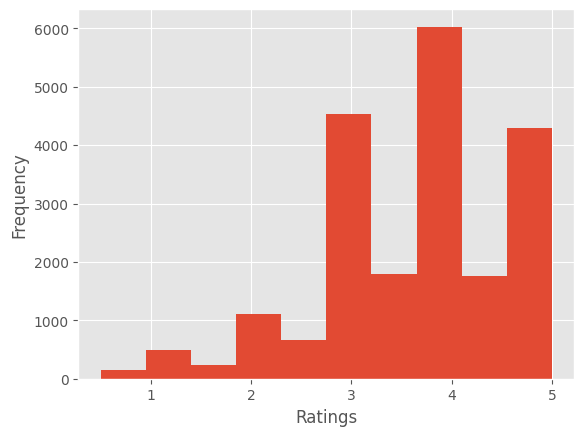

In [ ]:
print("Frequency of each rating from 0.5 to 5.0:\n")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data['rating'].plot(kind = 'hist', bins = 10)
plt.xlabel('Ratings')

We can observe that most users rate movies in the range of 3 to 5, with 4 being the most common ratings.

Now, we can also observe that the userIds and movieIds are not continuous in our dataset. Hence, we can use SKLearn's Label Encoders to assign unique sequential IDs starting at zero, which is required later in our model.

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE_user = LabelEncoder()
LE_movie = LabelEncoder()
data['UniqueUserId'] = LE_user.fit_transform(data['userId'].values)
data['UniqueMovieId'] = LE_movie.fit_transform(data['movieId'].values)
data

,movieId,title,genres,userId,rating,timestamp,UniqueUserId,UniqueMovieId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47,2,0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52,5,0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51,7,0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47,9,0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41,10,0
...,...,...,...,...,...,...,...,...
21028,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,425,5.0,2014-12-07 04:07:31,422,252
21029,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,431,5.0,2010-11-06 13:37:20,428,252
21030,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,440,3.5,2010-06-03 14:37:59,437,252
21031,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,454,3.5,2014-06-16 09:45:31,451,252


Text(0.5, 0, 'movieId')

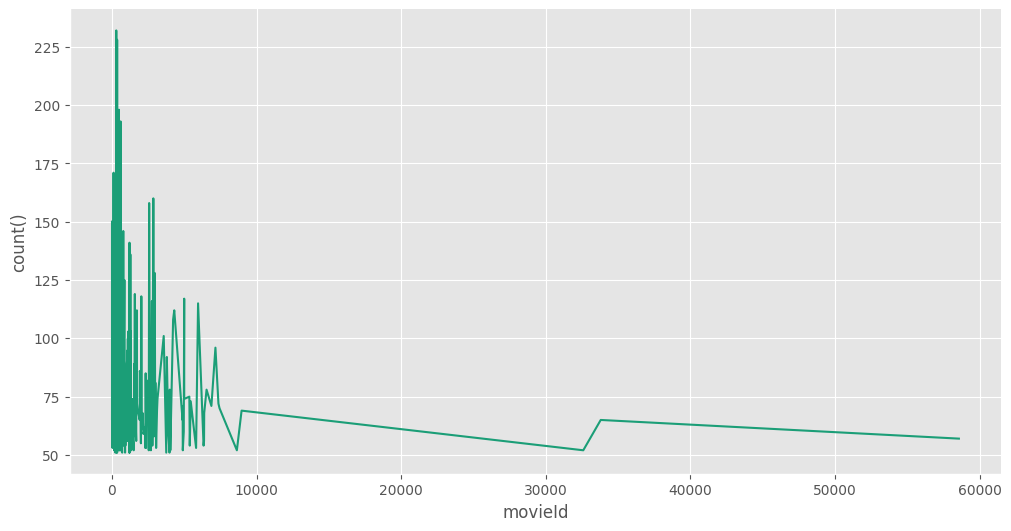

In [ ]:
# @title movieId vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['movieId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'movieId'}, axis=1)
              .sort_values('movieId', ascending=True))
  xs = counted['movieId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('movieId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('movieId')
_ = plt.ylabel('count()')

<Axes: xlabel='movieId', ylabel='userId'>

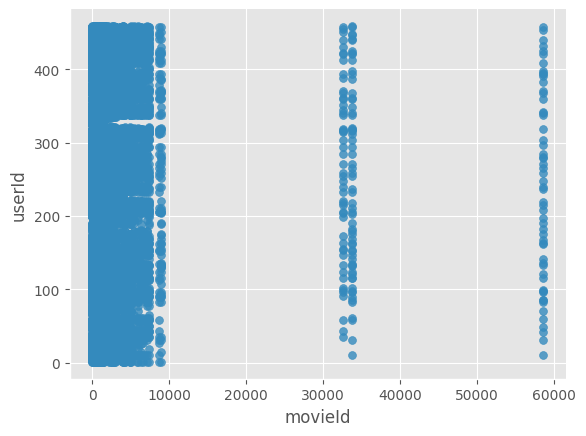

In [ ]:
# @title movieId vs userId

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='movieId', y='userId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Let us also make a few functions for ease of conversion between these values that will be required later.

In [ ]:
data_np = data.to_numpy()
print(data_np)
def movieId_to_title(id):
  for row in data_np:
    if row[0] == id:
      title = row[1]
      return title

def unique_movieId_to_title(uid):
  for row in data_np:
    if row[6] == uid:
      title = row[1]
      return title

def movieId_to_unique_movieId(id):
  for row in data_np:
    if row[0] == id:
      uid = row[6]
      return uid

def unique_movieId_to_movieId(uid):
  for row in data_np:
    if row[6] == uid:
      id = row[1]
      return id

[[1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy' ...
  '1999-12-11 13:36:47' 2 0]
 [1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy' ...
  '1997-03-13 17:50:52' 5 0]
 [1 'Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy' ...
  '1996-06-05 13:37:51' 7 0]
 ...
 [58559 'Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX' ...
  '2010-06-03 14:37:59' 437 252]
 [58559 'Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX' ...
  '2014-06-16 09:45:31' 451 252]
 [58559 'Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX' ...
  '2010-10-07 14:02:46' 454 252]]


We will now create our ( [UserId, MovieId] , Rating) pairing of data and label that will be input into our model for training. We will not be using a testing or a validation dataset, as our end objective is not to make accurate predictions on new data, but learn the best entitiy embeddings.

In [ ]:
X = data[['UniqueUserId', 'UniqueMovieId']].values
y = data['rating'].values
# print("Input = ['UniqueUserId', 'UniqueMovieId'] :\n", X, "\n")
X_array = [X[:, 0], X[:, 1]]
print("Input (X_combined): ", X_array, "\n")
print("Output (Rating) :", y, "\n")

Input (X_combined):  [array([  2,   5,   7, ..., 437, 451, 454]), array([  0,   0,   0, ..., 252, 252, 252])] 

Output (Rating) : [4.  5.  4.  ... 3.5 3.5 4.5] 



In [ ]:
from keras.layers import Input, Dot, Reshape, Dense, Add, Activation, Lambda
from keras.layers import Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

def Movie_Embedding_Network(n_users, n_movies, embedding_size, min_rating, max_rating):

  #Input -> UserId followed by movieId
  users = Input(name = 'users', shape = (1,))
  movies = Input(name = 'movies', shape = (1,))

  #Create Embedding Layers
  users_embedding = Embedding(name = 'users_embeddings', input_dim = n_users, output_dim = embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(users)
  movies_embedding = Embedding(name = 'movies_embeddings', input_dim = n_movies, output_dim = embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(movies)

  #Reshaping the Embedding Layers
  reshaped_users_embedding = Reshape((embedding_size,), name = 'reshaped_users_embeddings')(users_embedding)
  reshaped_movies_embedding = Reshape((embedding_size,), name = 'reshaped_movies_embeddings')(movies_embedding)

  #Taking the dot product of the two embedding layers
  merged = Dot(name = 'dot_product', normalize = True, axes = 1)([reshaped_movies_embedding, reshaped_users_embedding])

  #Creating Embedding layers of size (1) for calculating bias.
  movies_bias = Embedding(name = 'movies_bias', input_dim = n_movies, output_dim = 1, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(movies)
  users_bias = Embedding(name = 'users_bias', input_dim = n_users, output_dim = 1, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(users)

  #Reshaping the Bias Embedding Layers
  reshaped_movies_bias = Reshape((1,), name = 'reshaped_movies_bias')(movies_bias)
  reshaped_users_bias = Reshape((1,), name = 'reshaped_users_bias')(users_bias)

  #Adding the Bias Layers to our dot product merged layer
  merged_w_bias = Add(name = 'bias_addition')([merged, reshaped_movies_bias, reshaped_users_bias])

  # Running the output of our dot product layer through a sigmoid activation layer and then scaling the outputs to our rating range for non-linearity
  activated = Activation('sigmoid')(merged_w_bias)
  scaled = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(activated)

  model = Model(inputs=[users, movies], outputs=scaled)
  model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
  return model

embedding_size = 50
model = Movie_Embedding_Network(n_users, n_movies, embedding_size, min_rating, max_rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movies (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 users (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 movies_embeddings (Embeddi  (None, 1, 50)                12650     ['movies[0][0]']              
 ng)                                                                                              
                                                                                                  
 users_embeddings (Embeddin  (None, 1, 50)                22850     ['users[0][0]']           

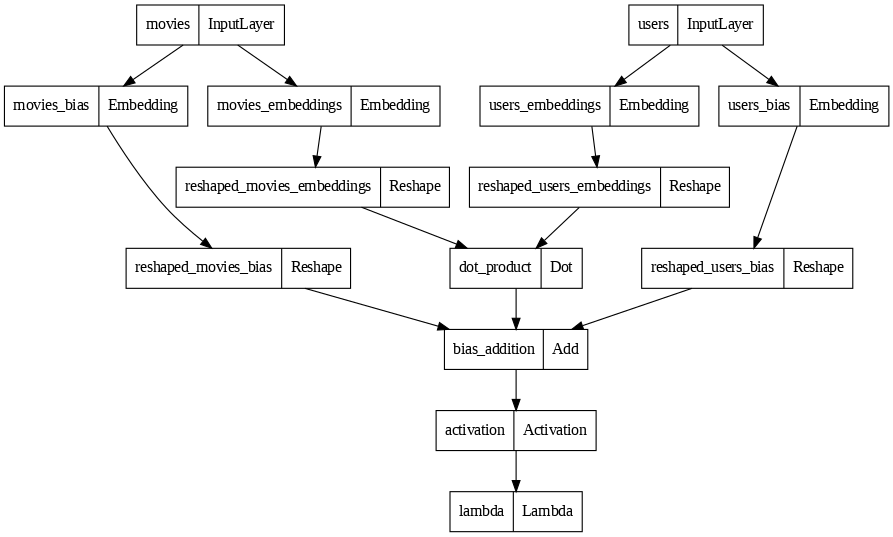

In [ ]:
from keras.utils import plot_model
plot_model(model, rankdir= 'TR', dpi = 80)

We will use keras ModelCheckcoint for saving our best models which minimise the loss.

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/MovieLens/models/best_attempt.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
%time
epochs = 15

history = model.fit(x=X_array, y=y, epochs=epochs, batch_size=1000,
                    verbose=1, callbacks=callbacks_list)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
Epoch 1/15
15/22 [===================>..........] - ETA: 0s - loss: 1.9685  
Epoch 1: loss improved from inf to 1.96675, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
22/22 [==============================] - 5s 6ms/step - loss: 1.9668
Epoch 2/15
17/22 [======================>.......] - ETA: 0s - loss: 1.8466
Epoch 2: loss improved from 1.96675 to 1.84039, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
22/22 [==============================] - 0s 5ms/step - loss: 1.8404
Epoch 3/15
17/22 [======================>.......] - ETA: 0s - loss: 1.7466

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: loss improved from 1.84039 to 1.73115, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
22/22 [==============================] - 0s 5ms/step - loss: 1.7311
Epoch 4/15
16/22 [====================>.........] - ETA: 0s - loss: 1.6288
Epoch 4: loss improved from 1.73115 to 1.62478, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
22/22 [==============================] - 0s 4ms/step - loss: 1.6248
Epoch 5/15
17/22 [======================>.......] - ETA: 0s - loss: 1.5377
Epoch 5: loss improved from 1.62478 to 1.51935, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
22/22 [==============================] - 0s 4ms/step - loss: 1.5193
Epoch 6/15
14/22 [==================>...........] - ETA: 0s - loss: 1.4201
Epoch 6: loss improved from 1.51935 to 1.41253, saving model to /content/gdrive/My Drive/MovieLens/models/best_attempt.h5
22/22 [==============================] - 0s 5ms/step - loss: 1.4125
Epoch 7/15
16/

In [ ]:
#Loading Best Weights
model.load_weights("/content/gdrive/My Drive/MovieLens/models/best_attempt.h5")

In [ ]:
#Saving Best Model
model.save("/content/gdrive/My Drive/MovieLens/models/best_attempt.h5")

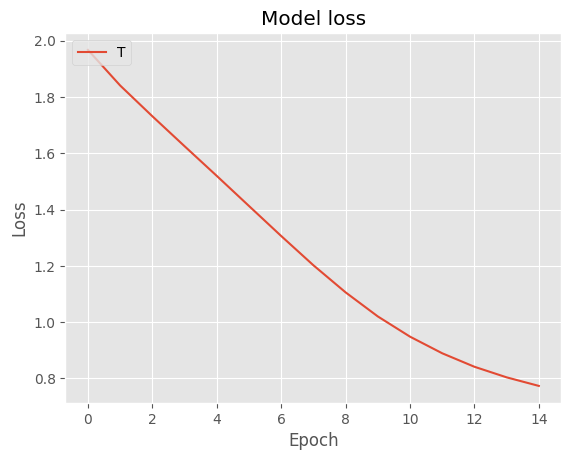

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Training Loss', loc='upper left')
plt.show()

In [ ]:
movie_layer = model.get_layer('movies_embeddings')
movie_weights = movie_layer.get_weights()[0]
print(movie_weights.shape)
print(movie_weights[0])

(253, 50)
[-6.7097172e-02 -1.4265195e-01 -1.5428512e-01 -1.0658586e-01
 -9.2292011e-02 -3.2320410e-02 -4.9883291e-02 -5.4766675e-03
 -1.6402966e-01  8.3689779e-02 -8.0982514e-02 -1.5178892e-02
  1.6185135e-02  1.5356126e-03  1.2453908e-02  4.0904216e-02
 -7.0977718e-02 -1.7314830e-01  8.9079641e-02 -5.2969493e-02
 -9.7252384e-02 -2.2824747e-02 -4.4960577e-02  7.3480614e-02
 -1.0135174e-01 -5.6366671e-02 -6.2172502e-02 -2.1662037e-01
  1.4810334e-01  7.9901762e-02 -1.4817964e-01  1.5536578e-01
 -4.4239037e-02 -7.4746810e-02 -1.4009428e-01 -2.3439042e-02
  7.7869996e-02  8.1767753e-02 -1.3617176e-01 -2.1446404e-01
  9.0114968e-03  6.2080011e-02  1.3357463e-04  2.1121560e-03
  8.0182619e-02  8.0220714e-02  1.2731512e-01 -4.6309426e-02
 -1.6000083e-03  2.1315046e-02]


In [ ]:
movie_weights_normalised = movie_weights / np.linalg.norm(movie_weights, axis = 1).reshape((-1, 1))
print(movie_weights_normalised[0])
np.sum(np.square(movie_weights_normalised[0]))

[-9.92185622e-02 -2.10943624e-01 -2.28145942e-01 -1.57611653e-01
 -1.36474907e-01 -4.77931425e-02 -7.37638921e-02 -8.09850916e-03
 -2.42555484e-01  1.23754539e-01 -1.19751222e-01 -2.24454738e-02
  2.39334349e-02  2.27075559e-03  1.84159596e-02  6.04862683e-02
 -1.04956843e-01 -2.56039500e-01  1.31724685e-01 -7.83275515e-02
 -1.43809959e-01 -3.37516256e-02 -6.64845258e-02  1.08657949e-01
 -1.49871796e-01 -8.33510533e-02 -9.19363052e-02 -3.20322931e-01
  2.19004765e-01  1.18153088e-01 -2.19117582e-01  2.29743958e-01
 -6.54175654e-02 -1.10530309e-01 -2.07161531e-01 -3.46600004e-02
  1.15148656e-01  1.20912381e-01 -2.01361179e-01 -3.17134291e-01
  1.33255655e-02  9.17995423e-02  1.97520741e-04  3.12330713e-03
  1.18568398e-01  1.18624732e-01  1.88264608e-01 -6.84791133e-02
 -2.36597937e-03  3.15191858e-02]


1.0000001

In [ ]:
def movie_recommend(movieId, weights, n = 10):
  print("Printing recommendations for:", movieId_to_title(movieId), "\n\n")
  uid = movieId_to_unique_movieId(movieId)
  similarity = np.dot(weights, weights[uid])
  # similarity = np.dot(weights, weights.T)  # Matrix multiplication with transposed weights

  #print(similarity)
  sorted_sim = np.argsort(similarity)
  closest = sorted_sim[-n-1:-1]
  #print(closest)
  count = 0
  for i in reversed(closest):
    count = count + 1
    print(f'{count:{2}}: {unique_movieId_to_title(i):{80}} ---> Similarity: ", {(similarity[i]):{.2}}')

In [ ]:
movie_recommend(1, movie_weights_normalised)

Printing recommendations for: Toy Story (1995) 


 1: Toy Story (1995)                                                                 ---> Similarity: ", 0.6
 2: Braveheart (1995)                                                                ---> Similarity: ", 0.54
 3: Ace Ventura: When Nature Calls (1995)                                            ---> Similarity: ", 0.53
 4: Toy Story (1995)                                                                 ---> Similarity: ", 0.52
 5: Toy Story (1995)                                                                 ---> Similarity: ", 0.51
 6: Toy Story (1995)                                                                 ---> Similarity: ", 0.51
 7: GoldenEye (1995)                                                                 ---> Similarity: ", 0.5
 8: Clockwork Orange, A (1971)                                                       ---> Similarity: ", 0.5
 9: Jumanji (1995)                                                       

In [ ]:
movie_recommend(2858, movie_weights_normalised)

Printing recommendations for: American Beauty (1999) 


 1: Toy Story (1995)                                                                 ---> Similarity: ", 0.5
 2: Jumanji (1995)                                                                   ---> Similarity: ", 0.48
 3: Pulp Fiction (1994)                                                              ---> Similarity: ", 0.46
 4: Braveheart (1995)                                                                ---> Similarity: ", 0.44
 5: Ace Ventura: When Nature Calls (1995)                                            ---> Similarity: ", 0.41
 6: Toy Story (1995)                                                                 ---> Similarity: ", 0.4
 7: Toy Story (1995)                                                                 ---> Similarity: ", 0.4
 8: Braveheart (1995)                                                                ---> Similarity: ", 0.4
 9: Sense and Sensibility (1995)                                    

In [ ]:
movie_recommend(260, movie_weights_normalised)

Printing recommendations for: Star Wars: Episode IV - A New Hope (1977) 


 1: Casino (1995)                                                                    ---> Similarity: ", 0.78
 2: Heat (1995)                                                                      ---> Similarity: ", 0.75
 3: Toy Story (1995)                                                                 ---> Similarity: ", 0.74
 4: Apollo 13 (1995)                                                                 ---> Similarity: ", 0.72
 5: Casino (1995)                                                                    ---> Similarity: ", 0.7
 6: Sense and Sensibility (1995)                                                     ---> Similarity: ", 0.69
 7: Sense and Sensibility (1995)                                                     ---> Similarity: ", 0.69
 8: Toy Story (1995)                                                                 ---> Similarity: ", 0.69
 9: Jumanji (1995)                            

In [ ]:
def movie_recommend_multiInput(movieIds, weights, n=10):
    recs = []
    for movieId in movieIds:
      uid = movieId_to_unique_movieId(movieId)
      similarity = np.dot(weights, weights[uid])
      #print(similarity)
      sorted_sim = np.argsort(similarity)
      # closest = sorted_sim[-n-1:-1]
      if len(sorted_sim) < n:
        n = len(sorted_sim)  # Adjust n to available similar movies
      closest = sorted_sim[-n-1:-1]
      print(closest)
      count = 0
      for i in reversed(closest):
        recs.append({"Movie_Name":unique_movieId_to_title(i), "Similarity":similarity[i]})
    combined_recs_sorted = sorted(recs, key = lambda i: i['Similarity'])
    print(combined_recs_sorted)
    for i in reversed(combined_recs_sorted[:10]):
      print(i)


In [ ]:
movie_recommend_multiInput([1, 260], movie_weights_normalised)

[ 42 131 222 206  83 231 128 233 137 219]
[102 131 132 227 244  19  42 123  47 210]
[{'Movie_Name': 'Apollo 13 (1995)', 'Similarity': 0.4911723}, {'Movie_Name': 'Jumanji (1995)', 'Similarity': 0.49480727}, {'Movie_Name': 'Clockwork Orange, A (1971)', 'Similarity': 0.49813256}, {'Movie_Name': 'GoldenEye (1995)', 'Similarity': 0.5013381}, {'Movie_Name': 'Toy Story (1995)', 'Similarity': 0.5086521}, {'Movie_Name': 'Toy Story (1995)', 'Similarity': 0.5114049}, {'Movie_Name': 'Toy Story (1995)', 'Similarity': 0.52172846}, {'Movie_Name': 'Ace Ventura: When Nature Calls (1995)', 'Similarity': 0.5261722}, {'Movie_Name': 'Braveheart (1995)', 'Similarity': 0.5437061}, {'Movie_Name': 'Toy Story (1995)', 'Similarity': 0.59640855}, {'Movie_Name': 'Naked Gun 33 1/3: The Final Insult (1994)', 'Similarity': 0.6835371}, {'Movie_Name': 'Jumanji (1995)', 'Similarity': 0.6898147}, {'Movie_Name': 'Toy Story (1995)', 'Similarity': 0.6906552}, {'Movie_Name': 'Sense and Sensibility (1995)', 'Similarity': 0.69

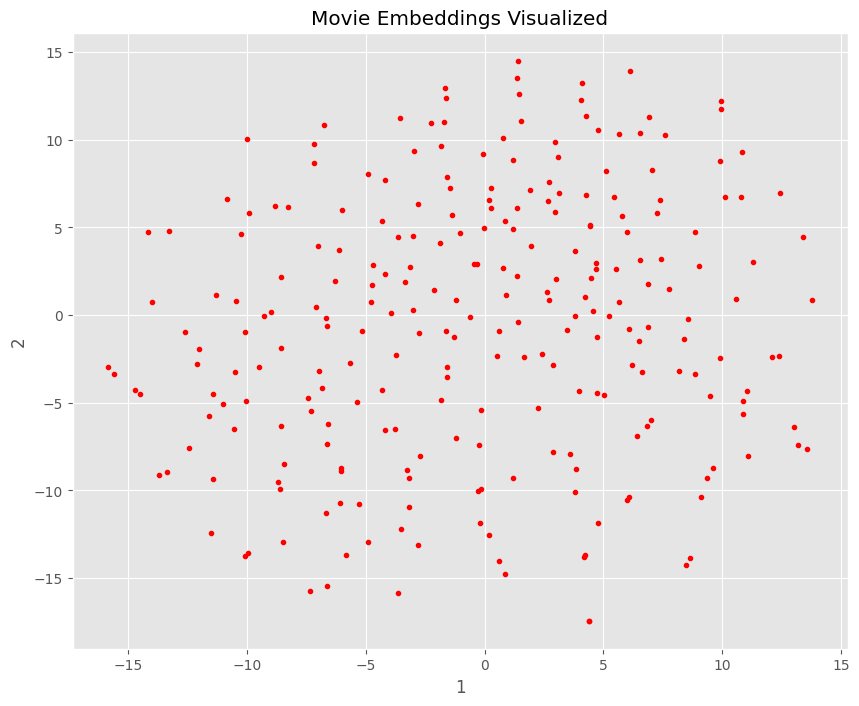

In [ ]:
from sklearn.manifold import TSNE
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#Reduce dimensions of embeddings
# def reduce_dim(weights, components):
#     return TSNE(components, metric = 'cosine').fit_transform(weights)
def reduce_dim(weights, perplexity=15, n_components=2):
    return TSNE(perplexity=perplexity, metric='cosine', n_components=n_components).fit_transform(weights)



# movie_r = reduce_dim(movie_weights_normalised, components = 2)
movie_r = reduce_dim(movie_weights_normalised, perplexity=15)


movie_r.shape

plt.figure(figsize = (10, 8))
plt.plot(movie_r[:, 0], movie_r[:, 1], 'r.')
plt.xlabel('1'); plt.ylabel('2'); plt.title('Movie Embeddings Visualized');

In [ ]:
import random
genres_list = data.loc[:,["UniqueMovieId","genres"]]
genres_list = genres_list.drop_duplicates()
# genres_list.to_numpy()
print(genres_list)

genre_index = []

def get_gen(gens):
  gen_to_include = ['comedy', 'drama', 'action', 'romance', 'sci-fi', 'horror', 'children']
  for i in gens:
    if i in gen_to_include:
      return i
    else:
      return gens[0]
for i in genres_list.iloc:
  gens = i[1]
  gens = list(gens.split('|'))
  genre_index.append({i[0]: get_gen(gens).lower()})
  #print(genre_index[:10])
print(genre_index[-10:])

genres = []

for i in genre_index:
  # if list(i.values())[0] not in set(genres):
  g = list(i.values())
  genres.append(g[0])
print(genres)


       UniqueMovieId                                       genres
0                  0  Adventure|Animation|Children|Comedy|Fantasy
150                1                   Adventure|Children|Fantasy
215                2                        Action|Crime|Thriller
289                3                    Action|Adventure|Thriller
381                4                         Comedy|Drama|Romance
...              ...                                          ...
20738            248                 Action|Adventure|Sci-Fi|IMAX
20790            249   Action|Adventure|Animation|Children|Comedy
20859            250      Action|Crime|Film-Noir|Mystery|Thriller
20911            251                            Action|Crime|IMAX
20976            252                      Action|Crime|Drama|IMAX

[253 rows x 2 columns]
[{243: 'action'}, {244: 'action'}, {245: 'action'}, {246: 'drama'}, {247: 'action'}, {248: 'action'}, {249: 'action'}, {250: 'action'}, {251: 'action'}, {252: 'action'}]
['adventure', 

In [ ]:
from collections import Counter, OrderedDict
def count_items(l):
    counts = Counter(l)
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    return counts

# Remove genres not found
genre_counts = count_items(genres)
list(genre_counts.items())[:10]

[('action', 98),
 ('comedy', 56),
 ('drama', 36),
 ('adventure', 29),
 ('crime', 18),
 ('children', 6),
 ('mystery', 4),
 ('animation', 3),
 ('horror', 2),
 ('thriller', 1)]

['Adventure' 'Action' 'Comedy' 'Crime' 'Drama' 'Mystery' 'Children'
 'Thriller' 'Animation' 'Horror']


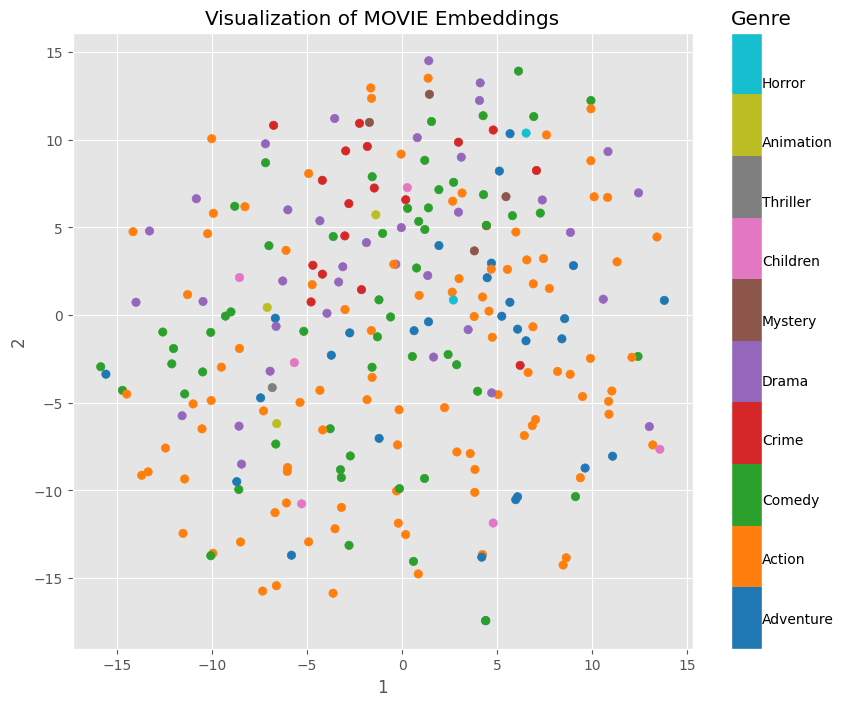

In [ ]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

idx_include = []
genres = []

for i in genre_index:
    if list(i.values())[0] in genre_to_include:
            idx_include.append(int(list(i.keys())[0]))
            genres.append(list(i.values())[0].capitalize())

len(idx_include)

ints, gen = pd.factorize(genres)
gen[:5]
plt.figure(figsize = (10, 8))

plt.scatter(movie_r[idx_include, 0], movie_r[idx_include, 1],
            c = ints, cmap = plt.cm.tab10)

cbar = plt.colorbar()
cbar.set_ticks([])
print(gen)
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((2.3) ), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')

plt.xlabel('1'); plt.ylabel('2'); plt.title('Visualization of MOVIE Embeddings');

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f70b41499abc51927e02740efac33b523f2a23c95f717b9f5d6f84d7b5ec883e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
movie_feature_names = None
if movie_feature_names is None:
  movie_feature_names = ["movie_feature_" + str(i) for i in range(movie_weights.shape[1])]

In [ ]:
from keras.models import load_model
import numpy as np
import lime
import lime.lime_tabular
from sklearn.preprocessing import LabelEncoder

# Load your trained model
model = load_model("/content/gdrive/My Drive/MovieLens/models/best_attempt.h5")

# Assuming you have the LabelEncoder objects LE_user and LE_movie from your previous code

def predict_fn(movie_embeddings):
    """
    Predict movie ratings using the trained model.

    Args:
        movie_embeddings (numpy.ndarray): Movie embeddings to predict ratings for.

    Returns:
        numpy.ndarray: Predicted ratings for the given movie embeddings.
    """
    # Assuming movie_embeddings is a 2D array with shape (n_movies, embedding_size)
    ratings = model.predict([movie_embeddings[:, 0], movie_embeddings[:, 1]])
    return ratings.flatten()  # Flatten to 1D array

# Define feature names for LIME
movie_feature_names = ["movie_feature_" + str(i) for i in range(embedding_size)]

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=movie_weights,  # Assuming movie_weights is your movie embeddings
    mode="regression",  # Assuming regression task for movie ratings
    feature_names=movie_feature_names
)

# Example usage to explain recommendation for a specific movie
movie_embedding_to_explain = movie_weights[0]  # Assuming you want to explain recommendations for the first movie
explanation = explainer.explain_instance(
    movie_embedding_to_explain,
    predict_fn,  # Provide the predict function
    top_labels=1  # Number of top labels to explain (adjust as needed)
)

# Print or visualize the explanation
print(explanation.as_list())


157/157 [==============================] - 0s 2ms/step
[('-0.11 < movie_feature_20 <= -0.05', 1.4271332869738978e-31), ('movie_feature_1 <= -0.10', 1.3514950501091323e-31), ('movie_feature_34 <= -0.08', 1.174233240166909e-31), ('movie_feature_2 <= -0.10', 9.616995095442935e-32), ('movie_feature_30 <= -0.11', 9.193933787548739e-32), ('-0.10 < movie_feature_16 <= -0.05', 7.408128410763407e-32), ('-0.11 < movie_feature_4 <= -0.06', 3.856524323136053e-32), ('movie_feature_33 <= -0.06', -2.979891874749326e-32), ('movie_feature_17 <= -0.13', -2.4550758886289903e-32), ('0.00 < movie_feature_40 <= 0.05', -1.4099136667667396e-33)]


In [ ]:
!pip install --upgrade lime


In [ ]:
# Assuming model is your trained movie recommendation model
model_weights = model.get_weights()[0]  # Assuming first layer weights (movie embeddings)
average_abs_weights = np.abs(model_weights).mean(axis=0)

# Sort features by importance (descending order)
sorted_feature_importance = np.argsort(average_abs_weights)[::-1]

# Print top N features (optional)
top_n_features = 10
print("Top", top_n_features, "Most Important Features for Movie Recommendations:")
for i in range(top_n_features):
  feature_index = sorted_feature_importance[i]
  print(f"{i+1}. Feature {feature_index}")  # Add meaningful feature names if available


Top 10 Most Important Features for Movie Recommendations:
1. Feature 8
2. Feature 15
3. Feature 9
4. Feature 27
5. Feature 29
6. Feature 17
7. Feature 39
8. Feature 46
9. Feature 13
10. Feature 30


In [ ]:
user_layer = model.get_layer('users_embeddings')
user_weights = user_layer.get_weights()[0]

average_abs_user_weights = np.abs(user_weights).mean(axis=0)
sorted_user_importance = np.argsort(average_abs_user_weights)[::-1]

# Print top N features (optional)
top_n_features = 10
print("Top", top_n_features, "Most Important User Features for Movie Recommendations:")
for i in range(top_n_features):
  feature_index = sorted_user_importance[i]
  # Replace 'user_feature_' with the actual names of your user features
  print(f"{i+1}. User Feature: user_feature_{feature_index}")


Top 10 Most Important User Features for Movie Recommendations:
1. User Feature: user_feature_8
2. User Feature: user_feature_9
3. User Feature: user_feature_15
4. User Feature: user_feature_27
5. User Feature: user_feature_17
6. User Feature: user_feature_46
7. User Feature: user_feature_13
8. User Feature: user_feature_31
9. User Feature: user_feature_30
10. User Feature: user_feature_38
